In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive/MyDrive/version_final_NLP_project/

/content/drive/MyDrive/version_final_NLP_project


# Import

In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import f1_score, classification_report, multilabel_confusion_matrix
from transformers import (
    XLMRobertaForSequenceClassification,
    XLMRobertaTokenizerFast,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from torch.utils.data import Dataset
import torch.nn as nn
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

import os


In [4]:
!pip install iterative-stratification

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [6]:
import wandb

wandb.init(mode="disabled")


# 1\) Data analysis

## English

In [7]:
data_eng = pd.read_csv(f'subtask3/train/eng.csv')

print(f"Columns: {data_eng.columns.tolist()}")

data_eng = data_eng.dropna(subset=['text'])
data_eng['text'] = data_eng['text'].astype(str)

label_cols = ['stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']

print(f"\n Label Distribution:")
for col in label_cols:
     if col in data_eng.columns:
         count = data_eng[col].sum()
         pct = (count / len(data_eng)) * 100
         print(f"  {col:20s}: {count:5d} ({pct:5.2f}%)")

data_eng['num_labels'] = data_eng[label_cols].sum(axis=1)
print(f"\n Multi-Label Statistics:")
print(data_eng['num_labels'].value_counts().sort_index())


Columns: ['id', 'text', 'stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']

 Label Distribution:
  stereotype          :   487 (15.11%)
  vilification        :   858 (26.63%)
  dehumanization      :   391 (12.14%)
  extreme_language    :   770 (23.90%)
  lack_of_empathy     :   357 (11.08%)
  invalidation        :   586 (18.19%)

 Multi-Label Statistics:
num_labels
0    2047
1     169
2     279
3     357
4     232
5     105
6      33
Name: count, dtype: int64



Generating Class Distribution Plot...


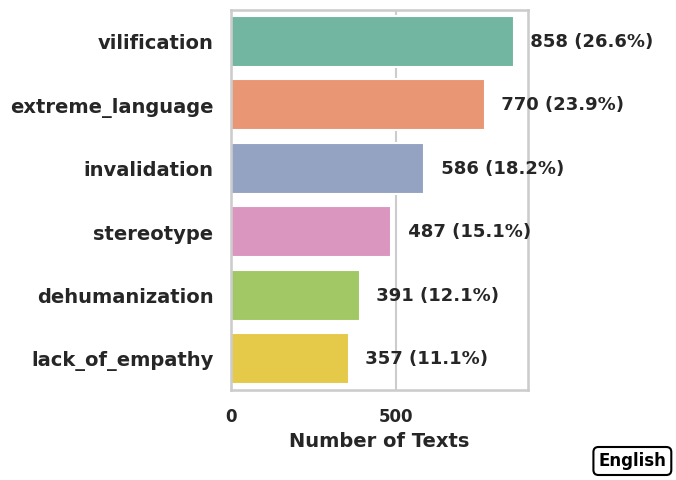

In [14]:

sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

df = data_eng
base_color = "#4c72b0"
palette = sns.color_palette("Set2", len(label_cols))


print("\nGenerating Class Distribution Plot...")

plt.figure(figsize=(7, 5))

counts = df[label_cols].sum().sort_values(ascending=False)
total_samples = len(df)

ax = sns.barplot(x=counts.values, y=counts.index, palette=palette, hue=counts.index, legend=False)

plt.xlabel("Number of Texts", fontsize=14, fontweight='bold')
plt.ylabel("")

plt.yticks(fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')

for i, v in enumerate(counts.values):
    pct = (v / total_samples) * 100

    ax.text(v + (total_samples * 0.01), i, f" {v} ({pct:.1f}%)", va='center', fontweight='bold', fontsize=13)

plt.tight_layout()
#plt.savefig("./image_saved/subtask3_class_distribution.pdf", format='pdf', bbox_inches='tight', dpi=300)


plt.figtext(
    0.98, 0.02, "English",
    ha='right', va='bottom',
    fontsize=12, fontweight='bold', color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)


plt.show()



Generating Cardinality Plot...


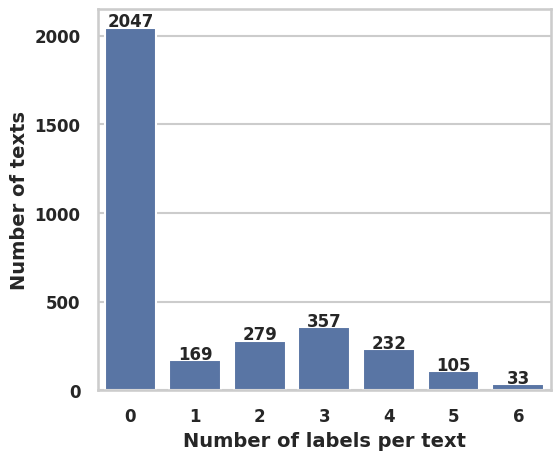

In [ ]:

print("Generating Cardinality Plot...")

plt.figure(figsize=(6, 5))

cardinality_counts = df['num_labels'].value_counts().sort_index()
ax = sns.barplot(x=cardinality_counts.index, y=cardinality_counts.values, color=base_color)

plt.xlabel("Number of labels per text", fontweight='bold', fontsize=14)
plt.ylabel("Number of texts", fontweight='bold', fontsize=14)

plt.yticks(fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)}', ha="center", fontsize=12, fontweight='bold')

plt.tight_layout()
#plt.savefig("./image_saved/subtask3_cardinality.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## Swahili

In [15]:
data_swa = pd.read_csv(f'subtask3/train/swa.csv')

print(f"Columns: {data_swa.columns.tolist()}")

data_swa = data_swa.dropna(subset=['text'])
data_swa['text'] = data_swa['text'].astype(str)

label_cols = ['stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']

print(f"\n Label Distribution:")
for col in label_cols:
     if col in data_swa.columns:
         count = data_swa[col].sum()
         pct = (count / len(data_swa)) * 100
         print(f"  {col:20s}: {count:5d} ({pct:5.2f}%)")

data_swa['num_labels'] = data_swa[label_cols].sum(axis=1)
print(f"\n Multi-Label Statistics:")
print(data_swa['num_labels'].value_counts().sort_index())


Columns: ['id', 'text', 'stereotype', 'vilification', 'dehumanization', 'extreme_language', 'lack_of_empathy', 'invalidation']

 Label Distribution:
  stereotype          :  2775 (39.69%)
  vilification        :  2883 (41.24%)
  dehumanization      :   893 (12.77%)
  extreme_language    :  1673 (23.93%)
  lack_of_empathy     :  2080 (29.75%)
  invalidation        :  1637 (23.42%)

 Multi-Label Statistics:
num_labels
0    3487
1     378
2     547
3     818
4     952
5     647
6     162
Name: count, dtype: int64



Generating Class Distribution Plot...


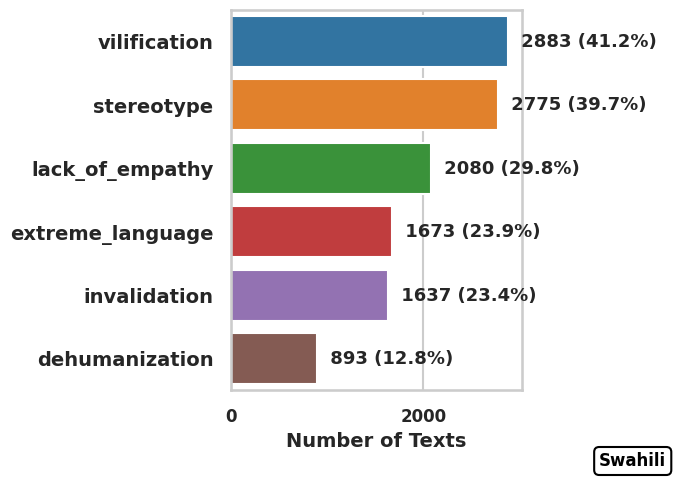

In [17]:
sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

df = data_swa
base_color = "#4c72b0"
palette = sns.color_palette("tab10", len(label_cols))


print("\nGenerating Class Distribution Plot...")

plt.figure(figsize=(7, 5))

counts = df[label_cols].sum().sort_values(ascending=False)
total_samples = len(df)

ax = sns.barplot(x=counts.values, y=counts.index, palette=palette, hue=counts.index, legend=False)

plt.xlabel("Number of Texts", fontsize=14, fontweight='bold')
plt.ylabel("")

plt.yticks(fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')

for i, v in enumerate(counts.values):
    pct = (v / total_samples) * 100

    ax.text(v + (total_samples * 0.01), i, f" {v} ({pct:.1f}%)", va='center', fontweight='bold', fontsize=13)

plt.tight_layout()
#plt.savefig("./image_saved/subtask3_distribution_swahili.pdf", format='pdf', bbox_inches='tight', dpi=300)


plt.figtext(
    0.98, 0.02, "Swahili",
    ha='right', va='bottom',
    fontsize=12, fontweight='bold', color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)
plt.show()



Generating Cardinality Plot...


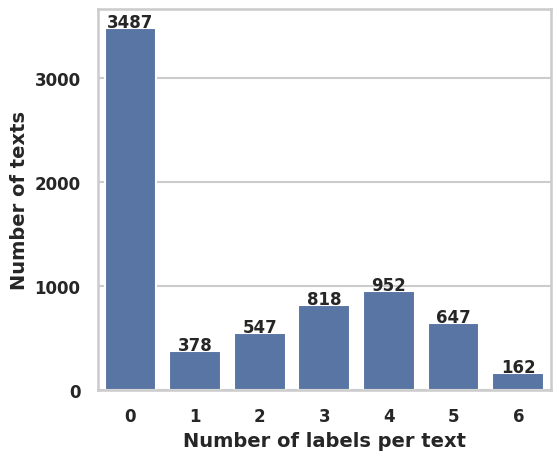

In [ ]:

print("Generating Cardinality Plot...")

plt.figure(figsize=(6, 5))

cardinality_counts = df['num_labels'].value_counts().sort_index()
ax = sns.barplot(x=cardinality_counts.index, y=cardinality_counts.values, color=base_color)

plt.xlabel("Number of labels per text", fontweight='bold', fontsize=14)
plt.ylabel("Number of texts", fontweight='bold', fontsize=14)

plt.yticks(fontsize=12, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width()/2., height + 5, f'{int(height)}', ha="center", fontsize=12, fontweight='bold')

plt.tight_layout()
#plt.savefig("./image_saved/subtask3_cardinality_swahili.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

# 2\) Model

In [8]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, hamming_loss
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import random
import os


In [9]:
# @title Hyperparameters
CONFIG = {
    'english': {
        'model_name': 'microsoft/mdeberta-v3-base',
        'model_name_en': 'cardiffnlp/twitter-roberta-base-sentiment-latest',
        'max_length': 128,
        'batch_size': 16,
        'learning_rate': 2e-5,
        'epochs': 10,
        'weight_decay': 0.01,
    },
    'swahili': {
        'model_name': 'microsoft/mdeberta-v3-base',
        'model_name_swa': 'Davlan/afro-xlmr-base',
        'max_length': 128,
        'batch_size': 16,
        'learning_rate': 2e-5,
        'epochs': 10,
        'weight_decay': 0.01,
    }
}

LABEL_COLUMNS = [
    'stereotype', 'vilification', 'dehumanization',
    'extreme_language', 'lack_of_empathy', 'invalidation'
]

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [10]:
# @title Data augmentation function
class DataAugmenter:
    """Generate text for data augmentation"""

    def __init__(self, language='english'):
        self.language = language

    def synonym_replacement(self, text, n=2):
        """Replace n words by their synonym"""

        if self.language == 'english':
            replacements = {
                'bad': ['terrible', 'awful', 'horrible'],
                'good': ['great', 'excellent', 'wonderful'],
                'people': ['folks', 'individuals', 'persons'],
                'hate': ['despise', 'detest', 'loathe'],
                'love': ['adore', 'cherish', 'treasure'],
                'stupid': ['dumb', 'idiotic', 'foolish'],
                'crazy': ['insane', 'mad', 'lunatic'],
            }
        else:
            return text

        words = text.split()
        replaced = 0

        for i, word in enumerate(words):
            if replaced < n and word.lower() in replacements:
                words[i] = random.choice(replacements[word.lower()])
                replaced += 1

        return ' '.join(words)

    def random_insertion(self, text, n=1):
        """Insert random word in the texts"""
        words = text.split()

        if len(words) < 3:
            return text

        for _ in range(n):
            random_word = random.choice(words)
            random_idx = random.randint(0, len(words))
            words.insert(random_idx, random_word)

        return ' '.join(words)

    def random_swap(self, text, n=1):
        """Exchange of words"""
        words = text.split()

        if len(words) < 2:
            return text

        for _ in range(n):
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]

        return ' '.join(words)

    def random_deletion(self, text, p=0.1):
        """Delete randomnly some words with probability p"""
        words = text.split()

        if len(words) == 1:
            return text

        new_words = [word for word in words if random.random() > p]

        if len(new_words) == 0:
            return random.choice(words)

        return ' '.join(new_words)

    def augment(self, text, num_augmented=2):
        augmented_texts = []

        techniques = [
            self.synonym_replacement,
            self.random_swap,
            self.random_deletion,
        ]

        for _ in range(num_augmented):
            technique = random.choice(techniques)
            augmented_text = technique(text)

            if random.random() > 0.5 and len(augmented_text.split()) > 3:
                technique2 = random.choice(techniques)
                augmented_text = technique2(augmented_text)

            augmented_texts.append(augmented_text)

        return augmented_texts


def augment_minority_classes(df, label_columns, target_samples_per_label=1500,
                             language='english', text_column='text_clean_advanced'):
    """
    Data augmentation

    Args:
        df: DataFrame
        label_columns: List
        target_samples_per_label: Number of target samples needed
        language: 'english' or 'swahili'
        text_column: column of text to add
    """


    augmenter = DataAugmenter(language=language)

    df_positive = df[df[label_columns].sum(axis=1) > 0].copy()
    df_negative = df[df[label_columns].sum(axis=1) == 0].copy()

    print(f"  - Instances positives (≥1 label): {len(df_positive)}")
    print(f"  - Instances negatives (0 label): {len(df_negative)}")

    label_counts = df_positive[label_columns].sum().sort_values()

    print(f"\n Labels Distribution (before augmentation):")
    for label, count in label_counts.items():
        print(f"  {label:20s}: {count:5d}")

    augmented_rows = []

    for label in label_columns:
        current_count = label_counts[label]

        if current_count < target_samples_per_label:
            needed = target_samples_per_label - current_count

            label_instances = df_positive[df_positive[label] == 1]

            print(f"\n  {label}: need {needed} sample supplementaries")

            augmentations_per_instance = max(1, needed // len(label_instances))

            for idx, row in label_instances.iterrows():
                augmented_texts = augmenter.augment(
                    row[text_column],
                    num_augmented=min(augmentations_per_instance, 3)
                )

                for aug_text in augmented_texts:
                    new_row = row.copy()
                    new_row[text_column] = aug_text
                    new_row['augmented'] = True
                    augmented_rows.append(new_row)

                    if len(augmented_rows) >= needed:
                        break

                if len(augmented_rows) >= needed:
                    break

    if augmented_rows:
        df_augmented = pd.DataFrame(augmented_rows)
        df_positive_augmented = pd.concat([df_positive, df_augmented], ignore_index=True)

        print(f" New instances created: {len(augmented_rows)}")
        print(f" Total instances positives: {len(df_positive_augmented)}")

        new_counts = df_positive_augmented[label_columns].sum()
        print(f"\n Labels Distribution (after augmentation):")
        for label in label_columns:
            before = label_counts[label]
            after = new_counts[label]
            increase = ((after - before) / before * 100) if before > 0 else 0
            print(f"  {label:20s}: {before:5d} → {after:5d} (+{increase:5.1f}%)")
    else:
        df_positive_augmented = df_positive

    return df_positive_augmented, df_negative



In [11]:
# @title Dataset, FocalLoss function
class PolarizationDataset(Dataset):
    """Dataset PyTorch pour classification multi-label"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }


class FocalLoss(torch.nn.Module):
    """For imbalanced class"""

    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()



In [12]:
# @title Trainer class
class MultiLabelTrainer(Trainer):
    """Trainer with Focal Loss"""

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Focal Loss
        loss_fct = FocalLoss(alpha=0.25, gamma=2.0)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [13]:
# @title compute metrics function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()
    predictions = (predictions > 0.5).astype(int)

    f1_micro = f1_score(labels, predictions, average='micro', zero_division=0)
    f1_macro = f1_score(labels, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(labels, predictions, average='weighted', zero_division=0)
    hamming = hamming_loss(labels, predictions)

    f1_per_class = f1_score(labels, predictions, average=None, zero_division=0)

    metrics = {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'hamming_loss': hamming,
    }

    for i, label_name in enumerate(LABEL_COLUMNS):
        metrics[f'f1_{label_name}'] = f1_per_class[i]

    return metrics




In [14]:
# @title train function
def train_model(df, language='english', output_dir='models',
                use_augmentation=True, target_samples=1500):

    config = CONFIG[language]
    model_name = config['model_name']

    print(f"\n Model: {model_name}")

    print("\n Load tokenizer and model")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(LABEL_COLUMNS),
        problem_type="multi_label_classification",
        ignore_mismatched_sizes=True
    )

    if use_augmentation:
        df_positive, df_negative = augment_minority_classes(
            df,
            LABEL_COLUMNS,
            target_samples_per_label=target_samples,
            language=language,
            text_column='text'
        )
    else:
        df_positive = df[df[LABEL_COLUMNS].sum(axis=1) > 0].copy()
        df_negative = df[df[LABEL_COLUMNS].sum(axis=1) == 0].copy()
        print(f"\n Augmentation desactivate")
        print(f" Instances positives: {len(df_positive)}")
        print(f" Instances négatives: {len(df_negative)}")

    n_negative = min(len(df_negative), int(len(df_positive) * 0.2))
    if n_negative > 0:
        df_negative_sample = df_negative.sample(n=n_negative, random_state=SEED)
        df_combined = pd.concat([df_positive, df_negative_sample], ignore_index=True)
        print(f"\n Add {n_negative} negatives instances  (balanced)")
    else:
        df_combined = df_positive

    print(f"\n Dataset final: {len(df_combined)} instances")

    train_val_df, test_df = train_test_split(
        df_combined,
        test_size=0.15,
        random_state=SEED,
        stratify=df_combined['num_labels'] if 'num_labels' in df_combined.columns else None
    )

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=0.15,
        random_state=SEED,
        stratify=train_val_df['num_labels'] if 'num_labels' in train_val_df.columns else None
    )


    print(f"Train: {len(train_df)} ({len(train_df)/len(df_combined)*100:.1f}%)")
    print(f"Val:   {len(val_df)} ({len(val_df)/len(df_combined)*100:.1f}%)")
    print(f"Test:  {len(test_df)} ({len(test_df)/len(df_combined)*100:.1f}%)")

    train_dataset = PolarizationDataset(
        train_df['text'].values,
        train_df[LABEL_COLUMNS].values,
        tokenizer,
        max_length=config['max_length']
    )

    val_dataset = PolarizationDataset(
        val_df['text'].values,
        val_df[LABEL_COLUMNS].values,
        tokenizer,
        max_length=config['max_length']
    )

    test_dataset = PolarizationDataset(
        test_df['text'].values,
        test_df[LABEL_COLUMNS].values,
        tokenizer,
        max_length=config['max_length']
    )

    training_args = TrainingArguments(
        output_dir=f"{output_dir}/{language}/argumented_model",
        num_train_epochs=config['epochs'],
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=config['batch_size'],
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        logging_dir=f"{output_dir}/{language}/logs",
        logging_steps=50,
        save_total_limit=1,
        seed=SEED,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )

    # Trainer
    trainer = MultiLabelTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()

    test_results = trainer.evaluate(test_dataset)

    print(f"\n Results ({language}):")
    print(f" F1 Micro:    {test_results['eval_f1_micro']:.4f}")
    print(f" F1 Macro:    {test_results['eval_f1_macro']:.4f}")
    print(f" F1 Weighted: {test_results['eval_f1_weighted']:.4f}")
    print(f" Hamming Loss: {test_results['eval_hamming_loss']:.4f}")

    print(f"\n F1-Score per label:")
    for label in LABEL_COLUMNS:
        print(f"  - {label:20s}: {test_results[f'eval_f1_{label}']:.4f}")

    final_model_path = f"{output_dir}/{language}/model_final"
    trainer.save_model(final_model_path)
    tokenizer.save_pretrained(final_model_path)

    print(f"\n Model saved: {final_model_path}")

    return trainer, test_results, test_df



In [15]:

# @title prediction function
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from tqdm import tqdm

class InferenceDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

def predict_multilabel(model_path, data_dev, thresholds=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer = AutoTokenizer.from_pretrained(model_path)

    model = AutoModelForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification")

    predict_dataset = InferenceDataset(data_dev['text'].tolist(), tokenizer)
    predict_loader = DataLoader(predict_dataset, batch_size=32, shuffle=False)

    model.to(device)
    model.eval()

    label_cols = [
    'stereotype', 'vilification', 'dehumanization',
    'extreme_language', 'lack_of_empathy', 'invalidation'
    ]
    if thresholds is None:
        thresholds = np.array([0.5] * 5)
    else:
        thresholds = np.array(thresholds)
        print(f"Threshold : {dict(zip(label_cols, thresholds))}")

    all_preds = []

    with torch.no_grad():
        for batch in tqdm(predict_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)

            probs = torch.sigmoid(outputs.logits)

            probs_np = probs.cpu().numpy()

            batch_preds = (probs_np > thresholds).astype(int)

            all_preds.extend(batch_preds)


    final_matrix = np.array(all_preds)

    for idx, col_name in enumerate(label_cols):
        data_dev[col_name] = final_matrix[:, idx]

    return data_dev


In [17]:

print("\n Loading data...")
df_english = pd.read_csv('subtask3/train/eng.csv')
df_swahili = pd.read_csv('subtask3/train/swa.csv')

print(f"  English: {len(df_english)} instances")
print(f"  Swahili: {len(df_swahili)} instances")

trainer_en, results_en, test_df_en = train_model(
    df_english,
    language='english',
    output_dir=f'model_subtask3/mdeberta_english/{CONFIG['english']['model_name']}',
    use_augmentation=True,
    target_samples=1500
)

print("-"*60)

trainer_sw, results_sw, test_df_sw = train_model(
    df_swahili,
    language='swahili',
    output_dir=f'model_subtask3/mdeberta_swahili/{CONFIG['swahili']['model_name']}',
    use_augmentation=True,
    target_samples=2500
)


print("English :")
print(f"  F1 Macro: {results_en['eval_f1_macro']:.4f}")
print(f"  F1 Micro: {results_en['eval_f1_micro']:.4f}")

print("Swahili :")
print(f"  F1 Macro: {results_sw['eval_f1_macro']:.4f}")
print(f"  F1 Micro: {results_sw['eval_f1_micro']:.4f}")




 Loading data...
  English: 3222 instances
  Swahili: 6991 instances

 Model: microsoft/mdeberta-v3-base

 Load tokenizer and model


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  - Instances positives (≥1 label): 1175
  - Instances negatives (0 label): 2047

 Labels Distribution (before augmentation):
  lack_of_empathy     :   357
  dehumanization      :   391
  stereotype          :   487
  invalidation        :   586
  extreme_language    :   770
  vilification        :   858

  stereotype: need 1013 sample supplementaries

  vilification: need 642 sample supplementaries

  dehumanization: need 1109 sample supplementaries

  extreme_language: need 730 sample supplementaries

  lack_of_empathy: need 1143 sample supplementaries

  invalidation: need 914 sample supplementaries
  - New instances created: 1144
  - Total instances positives: 2319

 Labels Distribution (after augmentation):
  stereotype          :   487 →  1543 (+216.8%)
  vilification        :   858 →  1747 (+103.6%)
  dehumanization      :   391 →   968 (+147.6%)
  extreme_language    :   770 →  1532 (+ 99.0%)
  lack_of_empathy     :   357 →   746 (+109.0%)
  invalidation        :   586 →  1145 

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,Hamming Loss,F1 Stereotype,F1 Vilification,F1 Dehumanization,F1 Extreme Language,F1 Lack Of Empathy,F1 Invalidation,Runtime,Samples Per Second,Steps Per Second
1,0.039900,0.036406,0.631818,0.472464,0.562965,0.304225,0.739336,0.822086,0.262069,0.728571,0.000000,0.282723,2.072300,171.307000,11.099000
2,0.036000,0.033825,0.708441,0.603904,0.667602,0.264319,0.786885,0.830709,0.651786,0.775330,0.120000,0.458716,1.437100,247.028000,16.005000
3,0.032100,0.032402,0.694820,0.610244,0.667843,0.254460,0.790816,0.828194,0.513966,0.734177,0.228571,0.565737,1.466200,242.116000,15.686000
4,0.028800,0.031638,0.759019,0.734468,0.759795,0.235211,0.822281,0.842742,0.692641,0.784922,0.603352,0.660870,1.450400,244.766000,15.858000
5,0.025500,0.029644,0.768432,0.733247,0.762334,0.209390,0.844560,0.855372,0.694064,0.778043,0.565789,0.661654,1.335100,265.894000,17.227000
6,0.022000,0.029876,0.779373,0.754206,0.776833,0.194836,0.850704,0.836207,0.705882,0.811456,0.654321,0.666667,1.599900,221.882000,14.375000
7,0.020000,0.029260,0.790280,0.769178,0.788832,0.186385,0.870968,0.840263,0.722772,0.794118,0.666667,0.720280,1.434100,247.541000,16.038000
8,0.017700,0.028985,0.791755,0.772122,0.791937,0.184977,0.883333,0.835886,0.709091,0.801980,0.677249,0.725191,2.015500,176.133000,11.411000
9,0.016600,0.029036,0.801853,0.783226,0.801977,0.180751,0.880886,0.849257,0.725664,0.809412,0.691489,0.742647,1.475000,240.672000,15.593000
10,0.015100,0.029078,0.802248,0.783164,0.802403,0.181690,0.879781,0.847458,0.731278,0.818824,0.687831,0.733813,1.605600,221.103000,14.325000



 Results (english):
 F1 Micro:    0.8005
 F1 Macro:    0.7776
 F1 Weighted: 0.7997
 Hamming Loss: 0.1950

 F1-Score per label:
  - stereotype          : 0.8584
  - vilification        : 0.8765
  - dehumanization      : 0.7111
  - extreme_language    : 0.8140
  - lack_of_empathy     : 0.6435
  - invalidation        : 0.7622

 Model saved: model_subtask3/mdeberta_english/microsoft/mdeberta-v3-base/english/model_final
------------------------------------------------------------

 Model: microsoft/mdeberta-v3-base

 Load tokenizer and model


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  - Instances positives (≥1 label): 3504
  - Instances negatives (0 label): 3487

 Labels Distribution (before augmentation):
  dehumanization      :   893
  invalidation        :  1637
  extreme_language    :  1673
  lack_of_empathy     :  2080
  stereotype          :  2775
  vilification        :  2883

  dehumanization: need 1607 sample supplementaries

  extreme_language: need 827 sample supplementaries

  lack_of_empathy: need 420 sample supplementaries

  invalidation: need 863 sample supplementaries
  - New instances created: 896
  - Total instances positives: 4400

 Labels Distribution (after augmentation):
  stereotype          :  2775 →  3433 (+ 23.7%)
  vilification        :  2883 →  3723 (+ 29.1%)
  dehumanization      :   893 →  1786 (+100.0%)
  extreme_language    :  1673 →  2243 (+ 34.1%)
  lack_of_empathy     :  2080 →  2691 (+ 29.4%)
  invalidation        :  1637 →  2105 (+ 28.6%)

 Add 880 negatives instances  (balanced)

 Dataset final: 5280 instances
  - Train: 3814

Epoch,Training Loss,Validation Loss,F1 Micro,F1 Macro,F1 Weighted,Hamming Loss,F1 Stereotype,F1 Vilification,F1 Dehumanization,F1 Extreme Language,F1 Lack Of Empathy,F1 Invalidation,Runtime,Samples Per Second,Steps Per Second
1,0.041300,0.039777,0.640876,0.398816,0.502001,0.348912,0.799644,0.834674,0.000000,0.021053,0.737527,0.000000,2.535300,265.848000,16.961000
2,0.038700,0.038388,0.650256,0.459070,0.548809,0.337290,0.809249,0.845420,0.000000,0.000000,0.737430,0.362319,2.454600,274.589000,17.518000
3,0.038200,0.038649,0.659158,0.561748,0.624122,0.344214,0.784437,0.813808,0.000000,0.556634,0.689655,0.525952,2.406900,280.025000,17.865000
4,0.037000,0.038233,0.685833,0.589377,0.651840,0.337784,0.801619,0.842942,0.050847,0.603989,0.737725,0.499139,2.550400,264.274000,16.860000
5,0.034900,0.039101,0.664282,0.593010,0.645509,0.324926,0.791757,0.821918,0.287582,0.522059,0.701333,0.433409,2.552300,264.074000,16.847000
6,0.031900,0.040837,0.675293,0.631565,0.671199,0.328882,0.787487,0.814028,0.446809,0.559177,0.696570,0.485323,2.391500,281.836000,17.981000
7,0.031000,0.040747,0.676021,0.613625,0.662100,0.319733,0.796592,0.825902,0.319489,0.537313,0.712182,0.490272,2.516200,267.862000,17.089000
8,0.030400,0.040808,0.694219,0.650373,0.689567,0.316518,0.807128,0.837306,0.465753,0.551724,0.701164,0.539162,2.607300,258.501000,16.492000
9,0.028800,0.042895,0.682406,0.636267,0.675840,0.316024,0.803419,0.814499,0.460674,0.548446,0.693548,0.497018,2.411100,279.536000,17.834000
10,0.029100,0.042604,0.688277,0.643720,0.683129,0.316271,0.807651,0.822176,0.466125,0.551971,0.704000,0.510397,2.435200,276.771000,17.657000



 Results (swahili):
 F1 Micro:    0.6826
 F1 Macro:    0.6394
 F1 Weighted: 0.6756
 Hamming Loss: 0.3319

 F1-Score per label:
  - stereotype          : 0.7954
  - vilification        : 0.8308
  - dehumanization      : 0.4241
  - extreme_language    : 0.5499
  - lack_of_empathy     : 0.6859
  - invalidation        : 0.5503

 Model saved: model_subtask3/mdeberta_swahili/microsoft/mdeberta-v3-base/swahili/model_final
  F1 Macro: 0.7776
  F1 Micro: 0.8005
  F1 Macro: 0.6394
  F1 Micro: 0.6826


In [20]:

def find_optimal_thresholds(trainer, val_dataset):
    predictions_output = trainer.predict(val_dataset)
    logits = predictions_output.predictions
    true_labels = predictions_output.label_ids


    probs = 1 / (1 + np.exp(-logits))

    best_thresholds = []
    class_names = [
    'stereotype', 'vilification', 'dehumanization',
    'extreme_language', 'lack_of_empathy', 'invalidation' ]

    for i in range(6):
        best_f1 = 0
        best_thresh = 0.5

        for t in np.arange(0.1, 1.0, 0.05):
            preds_col = (probs[:, i] > t).astype(int)
            score = f1_score(true_labels[:, i], preds_col)

            if score > best_f1:
                best_f1 = score
                best_thresh = t

        best_thresholds.append(best_thresh)
        print(f" {class_names[i]}: best thresholds = {best_thresh:.2f} (F1={best_f1:.3f})")

    return best_thresholds

label_cols = [
    'stereotype', 'vilification', 'dehumanization',
    'extreme_language', 'lack_of_empathy', 'invalidation' ]

model_path = 'model_subtask3/mdeberta_english/microsoft/mdeberta-v3-base/english/model_final'
#trainer_sw = AutoModelForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification")

tokenizer = AutoTokenizer.from_pretrained(model_path)

val_labels = test_df_en[label_cols].values.tolist()
val_dataset = PolarizationDataset(test_df_en['text'].tolist(), val_labels, tokenizer)
optimal_thresholds = find_optimal_thresholds(trainer_en, val_dataset)


The tokenizer you are loading from 'model_subtask3/mdeberta_english/microsoft/mdeberta-v3-base/english/model_final' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


 stereotype: best thresholds = 0.35 (F1=0.884)
 vilification: best thresholds = 0.50 (F1=0.877)
 dehumanization: best thresholds = 0.40 (F1=0.715)
 extreme_language: best thresholds = 0.50 (F1=0.814)
 lack_of_empathy: best thresholds = 0.50 (F1=0.643)
 invalidation: best thresholds = 0.50 (F1=0.762)


In [22]:
thresholds = [0.35, 0.50, 0.40, 0.50, 0.50, 0.50]

data_dev_eng = pd.read_csv("subtask3/dev/eng.csv")

df_resultat = predict_multilabel(
    model_path = 'model_subtask3/mdeberta_english/microsoft/mdeberta-v3-base/english/model_final',
    data_dev=data_dev_eng,
    thresholds=thresholds
)
label_cols = [
    'id','stereotype', 'vilification', 'dehumanization',
    'extreme_language', 'lack_of_empathy', 'invalidation' ]
pred_eng = df_resultat[label_cols]
pred_eng.to_csv("./model_subtask3/pred_eng_sub3.csv", index=False)


The tokenizer you are loading from 'model_subtask3/mdeberta_english/microsoft/mdeberta-v3-base/english/model_final' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Threshold : {'stereotype': np.float64(0.35), 'vilification': np.float64(0.5), 'dehumanization': np.float64(0.4), 'extreme_language': np.float64(0.5), 'lack_of_empathy': np.float64(0.5), 'invalidation': np.float64(0.5)}


100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


In [23]:
thresholds = [0.10, 0.10, 0.30, 0.30, 0.10, 0.10]

data_dev_swa = pd.read_csv("subtask3/dev/swa.csv")

df_resultat = predict_multilabel(
    model_path='model_subtask3/mdeberta_swahili/microsoft/mdeberta-v3-base/swahili/model_final',
    data_dev=data_dev_swa,
    thresholds=thresholds
)
label_cols = [
    'id','stereotype', 'vilification', 'dehumanization',
    'extreme_language', 'lack_of_empathy', 'invalidation' ]
pred_eng = df_resultat[label_cols]
pred_eng.to_csv("./model_subtask3/pred_swa_only.csv", index=False)


The tokenizer you are loading from 'model_subtask3/mdeberta_swahili/microsoft/mdeberta-v3-base/swahili/model_final' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Threshold : {'stereotype': np.float64(0.1), 'vilification': np.float64(0.1), 'dehumanization': np.float64(0.3), 'extreme_language': np.float64(0.3), 'lack_of_empathy': np.float64(0.1), 'invalidation': np.float64(0.1)}


100%|██████████| 11/11 [00:03<00:00,  3.55it/s]
